In [1]:
import numpy as np

def homogenize(wavelength1, intensity1, wavelength2, intensity2):
    """Homogenize two spectra to have the same wavelength axis.
    
    """
    assert np.unique(np.diff(wavelength1)).size == 1, "Wavelength1 must be uniformly spaced"
    assert np.unique(np.diff(wavelength2)).size == 1, "Wavelength2 must be uniformly spaced"
    min_wavelength = min(wavelength1.min(), wavelength2.min())
    max_wavelength = max(wavelength1.max(), wavelength2.max())
    left1 = int(wavelength1[0] - min_wavelength)
    right1 = max_wavelength - wavelength1[-1]
    wavelength1_new = np.arange(min_wavelength, min_wavelength+ left1, 1).tolist() + wavelength1.tolist() + np.arange(wavelength1[-1]+1, max_wavelength+1, 1.).tolist()
    wavelength1_new = np.array(wavelength1_new)
    intensity1_new = np.zeros_like(wavelength1_new)
    intensity1_new[left1:left1+len(intensity1)] = intensity1

    left2 = int(wavelength2[0] - min_wavelength)
    right2 = max_wavelength - wavelength2[-1]
    wavelength2_new = np.arange(min_wavelength, min_wavelength+ left2, 1).tolist() + wavelength2.tolist() + np.arange(wavelength2[-1]+1, max_wavelength+1, 1.).tolist()
    wavelength2_new = np.array(wavelength2_new)
    intensity2_new = np.zeros_like(wavelength2_new)
    intensity2_new[left2:left2+len(intensity2)] = intensity2

    return wavelength1_new, intensity1_new, intensity2_new

In [2]:
from microsim import schema as ms
EGFP = ms.Fluorophore.from_fpbase("EGFP")
EGFP.emission_spectrum.intensity
EGFP.emission_spectrum.wavelength
filterd = ms.Bandpass.from_fpbase('semrock-ff01-441-511-593-684-817')
fitc = ms.Fluorophore.from_fpbase("Fluorescein-fitc")
dapi = ms.Fluorophore.from_fpbase("DAPI")
tritc = ms.Fluorophore.from_fpbase("tetramethylrhodamine-tamra-tritc")

In [3]:
i1 = fitc.emission_spectrum.intensity
i1 = i1 / i1.sum()
lambda1 = fitc.emission_spectrum.wavelength
name1 = 'FITC'

i2 = dapi.emission_spectrum.intensity
i2 = i2 / i2.sum()
lambda2 = dapi.emission_spectrum.wavelength
name2 = 'DAPI'

w, i1, i2 = homogenize(lambda1,
                       i1,
                       lambda2,
                       i2)

i3 = tritc.emission_spectrum.intensity
i3 = i3 / i3.sum()
lambda3 = tritc.emission_spectrum.wavelength
name3 = 'TRITC'

w_final, i1, i3 = homogenize(w,
                       i1,
                       lambda3,
                       i3)

_, i2, i3 = homogenize(w,
                       i2,
                       w_final,
                       i3)

In [4]:
name1, name2

('FITC', 'DAPI')

In [5]:
def find_optimal_lambda_threshold(i1, i2):
    """
    Find the index such that the sum of intensities on the left side for i1 and right side for i2 is maximized.
    """
    max_sum = -1
    optimal_index = -1
    for idx in range(len(i1)):
        left_sum = i1[:idx].sum()
        right_sum = i2[idx:].sum()
        total_sum = left_sum + right_sum
        if total_sum > max_sum:
            max_sum = total_sum
            optimal_index = idx
    return optimal_index, max_sum

In [6]:
idx1, sum1 = find_optimal_lambda_threshold(i1, i2)
idx2, sum2 = find_optimal_lambda_threshold(i2, i1)

if sum1 > sum2:
    left = i1 
    middle = i2
    threshold_left_idx = idx1
    names = (name1, name2)
else:
    left = i2
    middle = i1
    threshold_left_idx = idx2
    names = (name2, name1)

right = i3
names = names + (name3,)

In [7]:
import matplotlib.pyplot as plt
# _,ax = plt.subplots(figsize=(4,4))
# ax.plot(w_final[:threshold_idx], left[:threshold_idx], label=names[0], c ='blue')
# ax.plot(w_final[threshold_idx:], left[threshold_idx:], c ='blue', linestyle='--')
# ax.plot(w_final[threshold_idx:], right[threshold_idx:], label=names[1], c ='orange')
# ax.plot(w_final[:threshold_idx], right[:threshold_idx], c ='orange', linestyle='--')
# ax.axvline(w_final[threshold_idx], color='k', linestyle='--', label='Optimal Threshold')

# ax.legend(loc ='upper right', fontsize=8)
# ax.set_xlabel('Wavelength (nm)')

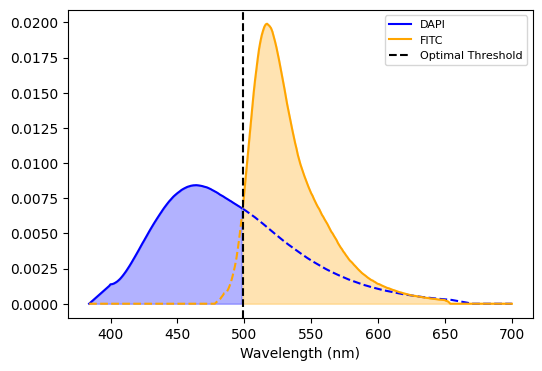

In [8]:
# ...existing code...
import matplotlib.pyplot as plt
_,ax = plt.subplots(figsize=(6,4))
ax.plot(w_final[:threshold_left_idx], left[:threshold_left_idx], label=names[0], c='blue')
ax.plot(w_final[threshold_left_idx:], left[threshold_left_idx:], c='blue', linestyle='--')
ax.plot(w_final[threshold_left_idx:], middle[threshold_left_idx:], label=names[1], c='orange')
ax.plot(w_final[:threshold_left_idx], middle[:threshold_left_idx], c='orange', linestyle='--')
ax.axvline(w_final[threshold_left_idx], color='k', linestyle='--', label='Optimal Threshold')

# fill under the solid (non-dashed) parts with matching colors
ax.fill_between(w_final[:threshold_left_idx], left[:threshold_left_idx], color='blue', alpha=0.3, zorder=0)
ax.fill_between(w_final[threshold_left_idx:], middle[threshold_left_idx:], color='orange', alpha=0.3, zorder=0)

ax.legend(loc='upper right', fontsize=8)
ax.set_xlabel('Wavelength (nm)')
plt.savefig('photon_efficiency_comparison_2Channel.png', dpi=150)
# ax.set_xlabel('Wavelength (

In [9]:
left[:threshold_left_idx].sum() + middle[threshold_left_idx:].sum()

1.5798110957783207

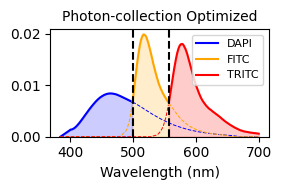

In [41]:
threshold_right_idx, _ = find_optimal_lambda_threshold(middle, right)
_,ax = plt.subplots(figsize=(3,2))
ax.plot(w_final[:threshold_left_idx], left[:threshold_left_idx], label=names[0], c='blue')
ax.plot(w_final[threshold_left_idx:], left[threshold_left_idx:], c='blue', linestyle='--',linewidth=0.7)
ax.plot(w_final[threshold_left_idx:threshold_right_idx], middle[threshold_left_idx:threshold_right_idx], label=names[1], c='orange')
ax.plot(w_final[:threshold_left_idx], middle[:threshold_left_idx], c='orange', linestyle='--',linewidth=0.7)
ax.plot(w_final[threshold_right_idx:], middle[threshold_right_idx:], c='orange', linestyle='--',linewidth=0.7)
ax.plot(w_final[threshold_right_idx:], right[threshold_right_idx:], c='red', label=names[2])
ax.plot(w_final[:threshold_right_idx], right[:threshold_right_idx], c='red', linestyle='--',linewidth=0.7)

ax.axvline(w_final[threshold_left_idx], color='k', linestyle='--')
ax.axvline(w_final[threshold_right_idx], color='k', linestyle='--')

# fill under the solid (non-dashed) parts with matching colors
ax.fill_between(w_final[:threshold_left_idx], left[:threshold_left_idx], color='blue', alpha=0.2, zorder=0)
ax.fill_between(w_final[threshold_left_idx:threshold_right_idx], middle[threshold_left_idx:threshold_right_idx], color='orange', alpha=0.2, zorder=0)
ax.fill_between(w_final[threshold_right_idx:], right[threshold_right_idx:], color='red', alpha=0.2, zorder=0)

ax.legend(loc='upper right', fontsize=8)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylim(0)
ax.set_title('Photon-collection Optimized', fontsize=10)

plt.tight_layout()
# save  with ddpi=150
plt.savefig('photon_efficiency_comparison_3Channel.pdf', dpi=150)

## Reducing half the bleedthrough

In [13]:
def move_left(arr, idx, fraction=0.5):
    """
    Move left of idx such that arr[:new_idx].sum() = fraction * arr[:idx].sum()
    """
    target_sum = arr[:idx].sum() * fraction
    cumulative_sum = 0
    new_idx = idx
    for i in range(idx-1, -1, -1):
        cumulative_sum += arr[i]
        if cumulative_sum >= target_sum:
            new_idx = i
            break
    return new_idx

def move_right(arr, idx, fraction=0.5):
    """
    Move right of idx such that arr[new_idx:].sum() = fraction * arr[idx:].sum()
    """
    target_sum = arr[idx:].sum() * fraction
    cumulative_sum = 0
    new_idx = idx
    for i in range(idx, len(arr)):
        cumulative_sum += arr[i]
        if cumulative_sum >= target_sum:
            new_idx = i
            break
    return new_idx

In [14]:
threshold_right_idx, _ = find_optimal_lambda_threshold(middle, right)
reduced_fraction = 0.25


In [92]:
def plot_efficiency_3channel(left, middle, right, reduced_fraction=0.0, savefig=False, title=None):
    threshold_left_idx, _ = find_optimal_lambda_threshold(left, middle)
    threshold_right_idx, _ = find_optimal_lambda_threshold(middle, right)

    left_start = 0
    if reduced_fraction > 0:
        left_end = move_left(middle, threshold_left_idx, fraction=reduced_fraction)
        right_start = move_right(middle, threshold_right_idx, fraction=reduced_fraction)
    else:
        left_end = threshold_left_idx
        right_start = threshold_right_idx

    
    right_start = max(right_start, move_right(left, threshold_right_idx, fraction=reduced_fraction) if reduced_fraction > 0 else threshold_right_idx)
    right_end = len(right)

    if reduced_fraction > 0:
        middle_start = move_right(left, threshold_left_idx, fraction=reduced_fraction)
        middle_end = move_left(right, threshold_right_idx, fraction=reduced_fraction)
    else:
        middle_start = threshold_left_idx
        middle_end = threshold_right_idx
    # 
    _,ax = plt.subplots(figsize=(3,2))
    ax.plot(w_final[left_start:left_end], left[left_start:left_end], label=names[0], c='blue')
    ax.plot(w_final[left_end:], left[left_end:], c='blue', linestyle='--', linewidth=0.7)

    ax.plot(w_final[middle_start:middle_end], middle[middle_start:middle_end], label=names[1], c='orange')
    ax.plot(w_final[:middle_start], middle[:middle_start], c='orange', linestyle='--',linewidth=0.7)
    ax.plot(w_final[middle_end:], middle[middle_end:], c='orange', linestyle='--',linewidth=0.7)

    ax.plot(w_final[right_start:right_end], right[right_start:right_end], c='red', label=names[2])
    ax.plot(w_final[right_end:], right[right_end:], c='red', linestyle='--',linewidth=0.7)
    ax.plot(w_final[:right_start], right[:right_start], c='red', linestyle='--',linewidth=0.7)

    # lines
    ax.axvline(w_final[left_start], color='blue', linestyle='--')
    ax.axvline(w_final[left_end], color='blue', linestyle='--')

    ax.axvline(w_final[middle_start], color='orange', linestyle='--')
    ax.axvline(w_final[middle_end], color='orange', linestyle='--')

    ax.axvline(w_final[right_start], color='red', linestyle='--')
    ax.axvline(w_final[right_end-1], color='red', linestyle='--')
    # fill under the solid (non-dashed) parts with matching colors
    ax.fill_between(w_final[left_start:left_end], left[left_start:left_end], color='blue', alpha=0.3, zorder=0)
    ax.fill_between(w_final[middle_start:middle_end], middle[middle_start:middle_end], color='orange', alpha=0.3, zorder=0)
    ax.fill_between(w_final[right_start:right_end], right[right_start:right_end], color='red', alpha=0.3, zorder=0)

    # fill bleedthrough for left channel
    ax.fill_between(w_final[left_start:left_end], middle[left_start:left_end], color='orange', alpha=0.3, zorder=0)
    ax.fill_between(w_final[left_start:left_end], right[left_start:left_end], color='red', alpha=0.3, zorder=0)

    # fill bleedthrough for middle channel
    ax.fill_between(w_final[middle_start:middle_end], left[middle_start:middle_end], color='blue', alpha=0.3, zorder=0)
    ax.fill_between(w_final[middle_start:middle_end], right[middle_start:middle_end], color='red', alpha=0.3, zorder=0)

    # fill bleedthrough for right channel
    ax.fill_between(w_final[right_start:right_end], left[right_start:right_end], color='blue', alpha=0.3, zorder=0)
    ax.fill_between(w_final[right_start:right_end], middle[right_start:right_end], color='orange', alpha=0.3, zorder=0)

    ax.legend(loc='upper right', fontsize=8, framealpha=0.95)
    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylim(0)
    # ax.set_yticklabels(ax.get_yticks(), rotation=45)
    ax.tick_params(axis='y', labelrotation=45)

    

    
    if title is not None:
        ax.set_title(title,fontsize=10)
    # save  with ddpi=150
    fname = f'photon_efficiency_comparison_3Channel_reduced_BT{reduced_fraction}.pdf'
    plt.tight_layout()
    if savefig:
        plt.savefig(fname, dpi=150)

    efficiency = (3 - (left[left_start:left_end].sum() + middle[middle_start:middle_end].sum() + right[right_start:right_end].sum()))/3 * 100
    print(f'Efficiency of a broad emiision filter: {efficiency}%')
    return fname

Efficiency of a broad emiision filter: 21.793962533327438%


'photon_efficiency_comparison_3Channel_reduced_BT0.0.pdf'

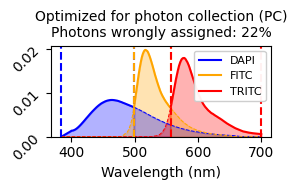

In [ ]:
# plot_efficiency_3channel(left, middle, right, reduced_fraction=0.25, title='Balanced (BT & PC)\nPhotons wrongly assigned + lost: 34%', savefig=True)
# plot_efficiency_3channel(left, middle, right, reduced_fraction=0.5, title='Optimized for Bleed-through (BT)\nPhotons wrongly assigned + lost: 55%', savefig=True)
# plot_efficiency_3channel(left, middle, right, reduced_fraction=0.0, title='Optimized for photon collection (PC)\nPhotons wrongly assigned: 22%', savefig=True)

In [46]:
# 0.25 150%
# 0.5 220.6%